# DSC 232R - Discussion 6: Paradigms, Trees, and Ensembles

## Agenda
1. **Paradigms of ML:** Generative vs. Discriminative, Optimization vs. Elimination, Confidence vs. Certainty.
2. **Decision Trees:** Splitting Criteria (Entropy vs. Error), Instability, and Big Data considerations.
3. **Ensembles:** Bagging (Variance Reduction) and Boosting (Bias Reduction).
4. **Code Demo:** Visualizing Tree Instability and the Random Forest solution.

---

## Part 1: Paradigms of Machine Learning

### 1.1 Generative vs. Discriminative Models
In machine learning, we generally categorize models into two approaches based on their goals:

* **Generative Models:** The goal is to explain *how* the data is generated. They model the joint probability distribution and are typically more accurate when their modeling assumptions are correct.
    * *Example:* Naive Bayes, GMMs.
* **Discriminative Models:** The goal is simply to predict a property (label) of the data. They generally model the conditional probability $P(Y|X)$ directly. These models are usually more robust against poor modeling assumptions or outliers.
    * *Example:* Logistic Regression, SVM, Decision Trees.

### 1.2 Optimization vs. Elimination
How do we actually "learn"?

1.  **Optimization:** The standard approach. We find the *single* model with the smallest loss on the training data.
2.  **Elimination:** A more robust, historically rooted approach (think Sherlock Holmes).
    * Instead of finding one "best" model, we use training data to eliminate models with high error, leaving a **Support Set** of acceptable models.
    * *Prediction:* We check the predictions of *all* models in the support set.
    * **Consensus:** If all models agree, we predict with confidence. If they disagree, the model outputs "I don't know".

### 1.3 Confidence vs. Certainty
A critical concept for real-world deployment is distinguishing between knowing the truth and knowing that you *know* the truth.

* **Certainty:** A statement about the *true distribution* of the world (e.g., a coin is truly biased).
* **Confidence:** A statement about *your knowledge* based on the training set.

**The Fishing Example:**
* **Low Certainty, High Confidence:** You go fishing in a new location. You know nothing about the probability of catching a fish (Low Certainty). However, you are highly confident *that* you know nothing (High Confidence in your ignorance).
* **High Certainty:** You fish for 100 days. You now have high confidence that your probability of catching a fish is > 5%.

**Why "I Don't Know" Matters:**
In ensemble learning (and elimination), if the support set contains models that disagree (e.g., some predict Class A, some predict Class B), the algorithm should output "I don't know" rather than guessing. This is crucial when an incorrect prediction is costly (e.g., losing 10) versus a neutral "I don't know" (gain/loss of 0).

---

## Part 2: Decision Trees

Decision trees are popular because they are flexible and easy to interpret. However, they have specific mathematical requirements for splitting and suffer from instability.

### 2.1 The Splitting Criteria (Why not Error Rate?)
When growing a tree, we split nodes to maximize "purity". A naive approach would be to minimize **Classification Error** ($min(p, 1-p)$). However, this fails in practice.

**The Problem with Error Rate:**
Consider a parent node with 80% (+) and 20% (-). The error rate is 20%. If we split it into two children with (90%+, 10%-) and (70%+, 30%-), the weighted average error might essentially remain 20%. There is **no gradient** to tell the algorithm this split helped, even though the children are purer.

**The Solution: Concavity**
We must use a **Strictly Concave** function to measure impurity.
1.  **Entropy:** $H(p) = -p \log(p) - (1-p) \log(1-p)$.
2.  **Gini Index:** $Gini(p) = p(1-p)$.

These functions curve downward (like an arch). This ensures that any split that makes children more pure than the parent results in a measurable reduction in impurity.

### 2.2 Big Data Considerations (Spark)
In traditional trees with continuous features, we sort the data to find the best split point.
* **Problem:** If you have 100 million examples in an RDD, sorting is too expensive.
* **Solution:** Use `Sample(false, 0.00001)` to get a small subset (e.g., 10k examples). Sort the sample to find **percentiles** (1%, 2%... 99%) and use those as candidate split points.

### 2.3 Instability and Overfitting
Trees are **High Variance** (Unstable) estimators.
* A "fully grown" tree (purity=100%) has 0 training error but likely high test error (Overfitting).
* **Instability:** Small changes in the training data can result in a completely different tree structure.

---

## Part 3: Ensembles (The Solution to Instability)

Ensembles are predictors defined as an average or vote over "base" predictors.

### 3.1 Bagging (Bootstrap Aggregation)
Bagging reduces variance by averaging many unstable models.
1.  **Bootstrap:** Create $N$ semi-independent datasets by sampling from the original data **with replacement**.
2.  **Aggregate:** Train a tree on each bootstrap sample and take the majority vote.

### 3.2 Random Forests
Random Forests are an improvement on Bagging designed to further **decorrelate** the trees.
* **Mechanism:** In addition to bootstrapping the data rows, at each split, the algorithm selects a **random subset of features**.
* **Why?** This prevents one very strong feature from dominating every single tree, ensuring the trees are different enough that averaging them actually helps.

### 3.3 Boosting (Gradient Tree Boosting)
While Bagging trains in parallel to reduce variance, Boosting trains **sequentially**.
* **Concept:** Each tree is trained to correct the mistakes (predict the residual error) of the previous tree.
* **Weights:** Examples that are hard to predict get higher weights.
* **Goal:** Primarily reduces **Bias** (but also Variance).

---

## Part 4: Practical Demonstration

We will now demonstrate **Tree Instability**. We will train a Decision Tree on a dataset, and then train another tree on the *exact same data* minus just a few points. You will see the decision boundary change drastically.

Then, we will show how a **Random Forest** smooths out this instability.

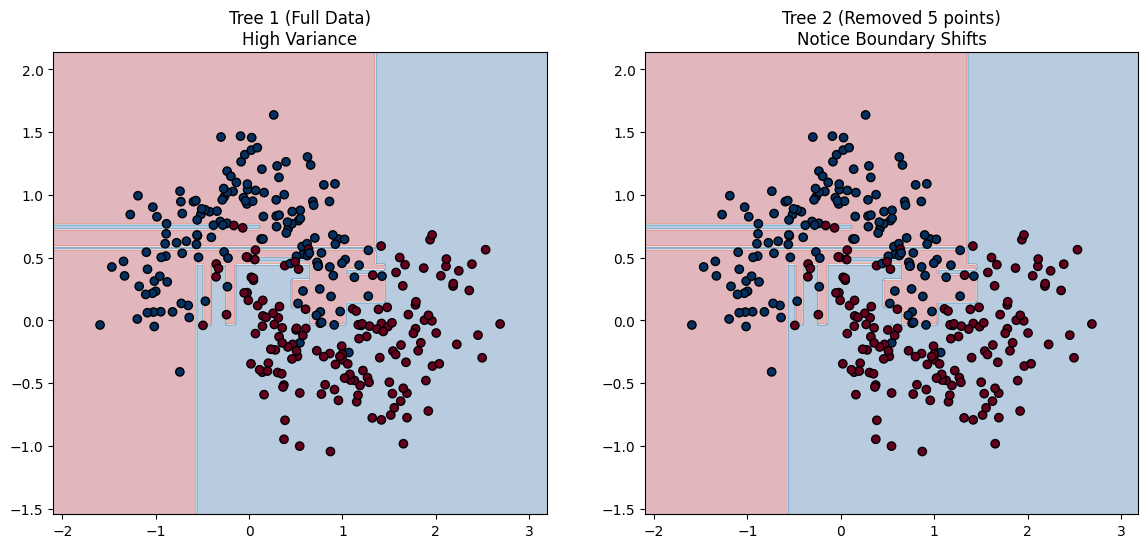

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# 1. Generate Synthetic Data (Moons dataset)
# We add noise to make the task harder, encouraging the tree to overfit
X, y = make_moons(n_samples=300, noise=0.25, random_state=42)

def plot_decision_boundary(clf, X, y, title, ax):
    """
    Helper function to visualize the classification boundary.
    """
    # Create a meshgrid to evaluate the classifier everywhere
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

    # Predict on the meshgrid
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot contour and data points
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdBu)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu_r, edgecolors='k')
    ax.set_title(title)

# 2. Demonstrate Instability
# Scenario: Tree 1 has full data. Tree 2 is missing just 5 data points.

# Tree 1: Full Data
tree_full = DecisionTreeClassifier(random_state=0)
tree_full.fit(X, y)

# Tree 2: Missing 5 points (Very small change in data)
X_perturbed = X[:-5]
y_perturbed = y[:-5]
tree_perturbed = DecisionTreeClassifier(random_state=0)
tree_perturbed.fit(X_perturbed, y_perturbed)

# Plotting the comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

plot_decision_boundary(tree_full, X, y, "Tree 1 (Full Data)\nHigh Variance", axes[0])
plot_decision_boundary(tree_perturbed, X_perturbed, y_perturbed, "Tree 2 (Removed 5 points)\nNotice Boundary Shifts", axes[1])

plt.show()

### Analysis of Instability
Notice in the plots above how the decision boundary (the separation between red and blue) changes shapes, specifically in the "noisy" regions. A stable model would not change its mind significantly just because 5 out of 300 data points were removed. This proves the concept: **"Trees are sensitive to small changes in the training set"**.

### Solution: Random Forest
Now we apply a Random Forest. Even though we are using the same noisy data, the ensemble method should produce a smoother, more stable boundary.

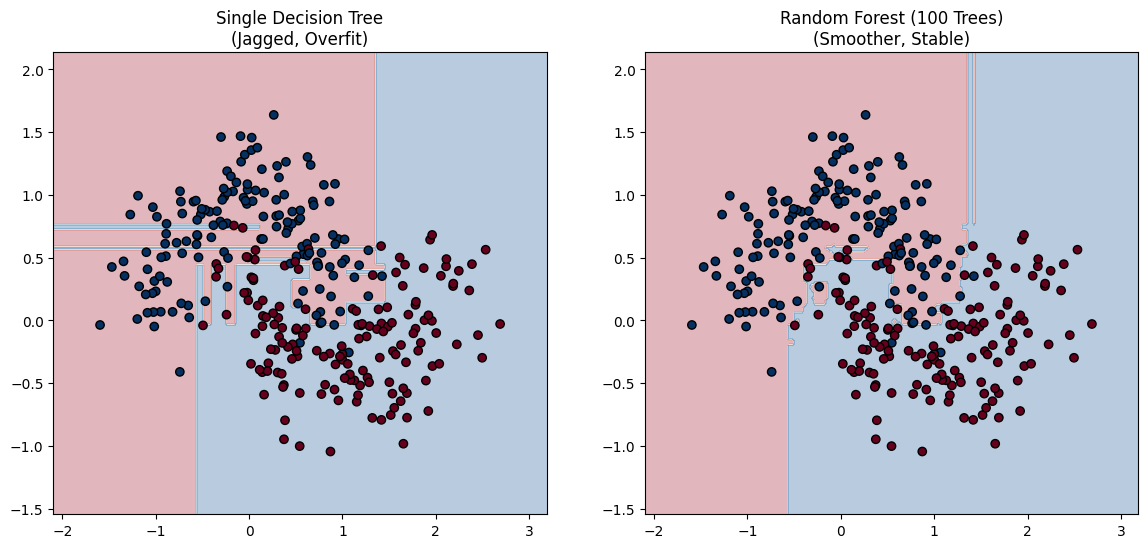

In [2]:
# 3. Demonstrate Random Forest (Stability)

# Random Forest with 100 trees
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X, y)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Re-plot the single tree for comparison
plot_decision_boundary(tree_full, X, y, "Single Decision Tree\n(Jagged, Overfit)", axes[0])

# Plot Random Forest
plot_decision_boundary(rf_clf, X, y, "Random Forest (100 Trees)\n(Smoother, Stable)", axes[1])

plt.show()

### Takeaway
The Random Forest boundary is much smoother. It ignores the specific noise of individual data points and captures the general "shape" of the data distribution. This illustrates the power of **Bagging** and **Feature Randomization** to reduce variance.